In [1]:
import time
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

import numpy as np
import hdbscan
# from tsnecuda import TSNE
# install T-SNE with cuda => 10x faster, highly recommended if running in CUDA machine
# !conda install tsnecuda -c conda-forge -y

# !pip install hdbscan

In [14]:
def get_user_repo_feat(data_df):
    return data_df.apply(
        lambda row: f"{row['user_name']}/{row['repo_name']}", axis=1
    ).tolist()


def get_watch_count_feat(data_df):
    watch_count = (
        pd.read_csv("../data/watch_count_public_data.csv")
        .rename(columns={"repo_name": "user/repo"})
        .drop(columns="Record Count")
    )
    return data_df.join(watch_count.set_index("user/repo"), on="user/repo")[
        "watch_count"
    ].tolist()



def get_user_repo_by_file_name(file_name):
    # get the repo and username from script file name
    script_file_name_regex = re.compile(r"data/([^/]+)/([^/]+)/.+")
    match = script_file_name_regex.search(file_name)
    username = match.group(1)
    repo_name = match.group(2)
    return username, repo_name

def read_py150k_code(filename, limit=None):
    filenames = []
    with open(filename, "r") as f:
        while True:
            line = f.readline()
            if not line:
                break
            filenames += [line.strip()]
            if limit and len(filenames) >= limit:
                break

    return filenames

PY150K_TRAIN_CODE = "../data/py150/py150_files/python100k_train.txt"

In [151]:
def get_high_freq_users(user_freq_dist, freq_thresh = 1000):
    users = []
    for user, freq in user_freq_dist:
        if freq < freq_thresh: continue
        users += [user]
    return users

In [152]:
import re

# sample code for loading Py150k code
code_filenames = read_py150k_code(PY150K_TRAIN_CODE)
u_list = []
r_list = []
for name in code_filenames:
    username, repo_name = get_user_repo_by_file_name(name)
    u_list += [username]
    r_list += [repo_name]

In [153]:
data = pd.read_csv('../data/py150k_metrics.csv')

In [154]:
train_data_df = data.copy()
train_data_df["user_name"] = u_list
train_data_df["repo_name"] = r_list
train_data_df["user/repo"] = get_user_repo_feat(train_data_df)
train_data_df["watch_count"] = get_watch_count_feat(train_data_df)
train_plot_df = train_data_df.dropna(subset=["watch_count"])

In [176]:
from collections import Counter
user_counter = Counter(train_data_df["user_name"])
user_freq_dist = user_counter.most_common(10)[:]
selected_users = get_high_freq_users(user_freq_dist, 0)
user_to_idx = {user:idx for idx, user in enumerate(selected_users)}
user_bool = train_data_df['user_name'].apply(lambda user: user in selected_users)
# train_data_df[user_bool]

In [185]:
user_freq_dist

[('anhstudios', 5069),
 ('openstack', 3111),
 ('AppScale', 1898),
 ('cloudera', 1033),
 ('tav', 852),
 ('dropbox', 805),
 ('dimagi', 785),
 ('mozilla', 753),
 ('GoogleCloudPlatform', 712),
 ('enthought', 700)]

In [177]:
sample = train_data_df[user_bool].loc[:]
len(sample)

15718

In [178]:

author_class = sample["user_name"].apply(lambda user: user_to_idx[user]).to_numpy()

In [179]:
full_rules = [
 'snake_case_var_ratio',
 'snake_case_class_ratio',
 'snake_case_method_ratio',
 'upper_camel_case_var_ratio',
 'upper_camel_case_class_ratio',
 'upper_camel_case_method_ratio',
 'upper_camel_case_var_ratio',
 'upper_camel_case_class_ratio',
 'upper_camel_case_method_ratio',
 'func_decotrators_avg',
 'class_decorators_avg',
 'class_parents_ratio',
# Comprehensions per script
# Generators per script
# Use of lambdas
 'comment_density',
 'ds_density',
]

In [180]:
def get_filtered_columns(data, rules):
    columns = data.columns
    results = set()
    for col in columns:
        match_flag = True
        
        for rule in rules:
            match_flag = rule in col and match_flag
        
        if match_flag:    
            results.add(col)
    return results

id_subset = get_filtered_columns(data, ["case"]).union(get_filtered_columns(data, ["id"]))
case_ratio_subset = get_filtered_columns(data, ["case", "ratio"])
normalized_subset = get_filtered_columns(data, ["ratio"])
density_subset = get_filtered_columns(data, ["density"])
full_subset = set()
for rule in full_rules:
    full_subset = full_subset.union(get_filtered_columns(data, [rule]))

In [181]:
subset = full_subset
X = sample[subset]

In [172]:
from gpu import get_free_gpu

In [173]:
get_free_gpu()

GPU usage:
  memory.used memory.free
0       2 MiB   24266 MiB
1   22225 MiB    2043 MiB
2   20205 MiB    4063 MiB
3    7859 MiB   16409 MiB
4   11122 MiB   13146 MiB
5   11082 MiB   13186 MiB
Returning GPU0 with 24266 free MiB


0

In [ ]:
# projection = TSNE(verbose=1, device=get_free_gpu()-1).fit_transform(X)
start_time = time.time()
projection = TSNE(verbose=1, learning_rate="auto", n_iter=250, n_iter_without_progress=1).fit_transform(X)
plt.scatter(*projection.T)
end_time = time.time()
end_time - start_time

In [182]:
from collections import Counter

def purity(cluster_labels, gold_labels):
    cluster_num = np.unique(cluster_labels).shape[0]
    cluster_sets = {}
    for cluster_label in np.unique(cluster_labels):
        cluster_sets[cluster_label] = []
    
    for idx, cluster_label in enumerate(cluster_labels):
        cluster_sets[cluster_label].append(gold_labels[idx])
    
    total_correct_pred = 0
    for c in np.unique(cluster_labels):
        label_counter = Counter(cluster_sets[c])
        pred_label, _ = label_counter.most_common(1)[0]
        total_correct_pred += label_counter[pred_label]
    
    purity = total_correct_pred / len(cluster_labels)
    
    return purity


In [183]:
min_samples = np.linspace(10, 500, 10, endpoint=True)
for m in min_samples:
    clusterer = hdbscan.HDBSCAN(min_samples=int(m), min_cluster_size=10, cluster_selection_epsilon = 0.05, prediction_data=True).fit(X.to_numpy())
    print(m, np.unique(clusterer.labels_).shape)
    print("purity: ", purity(clusterer.labels_, author_class))

In [188]:
sizes = np.linspace(10, 500, 3, endpoint=True)
epslons = np.linspace(0, 1, 3, endpoint=True)
for e in epslons:
    for m in sizes:
        for n in sizes:
            clusterer = hdbscan.HDBSCAN(min_samples=int(m), min_cluster_size=int(n), cluster_selection_epsilon = round(float(e),2), prediction_data=True).fit(X.to_numpy())
            print("min_samples", m)
            print("min_cluster_size", n)
            print("epsilon", round(float(e),2))
            print("cluster num", np.unique(clusterer.labels_).shape[0])
            print("purity: ", purity(clusterer.labels_, author_class))
            print("========================")

min_samples 10.0
min_cluster_size 10.0
epsilon 0.0
cluster num 63
purity:  0.5506425753912711
min_samples 10.0
min_cluster_size 255.0
epsilon 0.0
cluster num 7
purity:  0.5262756075836621
min_samples 10.0
min_cluster_size 500.0
epsilon 0.0
cluster num 5
purity:  0.5210586588624507
min_samples 255.0
min_cluster_size 10.0
epsilon 0.0
cluster num 14
purity:  0.5245578317852144
min_samples 255.0
min_cluster_size 255.0
epsilon 0.0
cluster num 5
purity:  0.5196589896933452
min_samples 255.0
min_cluster_size 500.0
epsilon 0.0
cluster num 4
purity:  0.5053441913729482
min_samples 500.0
min_cluster_size 10.0
epsilon 0.0
cluster num 16
purity:  0.5226491920091615
min_samples 500.0
min_cluster_size 255.0
epsilon 0.0
cluster num 4
purity:  0.5042626288331848
min_samples 500.0
min_cluster_size 500.0
epsilon 0.0
cluster num 3
purity:  0.4842855325104975
min_samples 10.0
min_cluster_size 10.0
epsilon 0.5
cluster num 3
purity:  0.3279679348517623
min_samples 10.0
min_cluster_size 255.0
epsilon 0.5
clu

In [ ]:
sample = train_plot_df.loc[:]
pop_class = (sample["watch_count"].to_numpy() > 300).astype(int)
subset = full_subset
X = sample[subset]
len(sample)
sizes = np.linspace(10, 500, 3, endpoint=True)
epslons = np.linspace(0, 1, 3, endpoint=True)
for e in epslons:
    for m in sizes:
        for n in sizes:
            clusterer = hdbscan.HDBSCAN(min_samples=int(m), min_cluster_size=int(n), cluster_selection_epsilon = round(float(e),2), prediction_data=True).fit(X.to_numpy())
            print("min_samples", m)
            print("min_cluster_size", n)
            print("epsilon", round(float(e),2))
            print("cluster num", np.unique(clusterer.labels_).shape[0])
            print("purity: ", purity(clusterer.labels_, pop_class))
            print("========================")

In [186]:
min_samples = np.linspace(10, 500, 10, endpoint=True)
for m in min_samples:
    clusterer = hdbscan.HDBSCAN(min_samples=150, min_cluster_size=int(m), cluster_selection_epsilon = 0.05, prediction_data=True).fit(X.to_numpy())
    print(m, np.unique(clusterer.labels_).shape)
    print("purity: ", purity(clusterer.labels_, author_class))

10.0 (14,)
purity:  0.5236035118971879
64.44444444444444 (5,)
purity:  0.5207405522331086
118.88888888888889 (5,)
purity:  0.5207405522331086
173.33333333333331 (5,)
purity:  0.5207405522331086
227.77777777777777 (5,)
purity:  0.5207405522331086
282.22222222222223 (5,)
purity:  0.5207405522331086
336.66666666666663 (5,)
purity:  0.5207405522331086
391.1111111111111 (5,)
purity:  0.5207405522331086
445.55555555555554 (5,)
purity:  0.5207405522331086
500.0 (4,)
purity:  0.5061076472833694


In [7]:
start_time = time.time()
clusterer = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=10 , cluster_selection_epsilon = 0, prediction_data=True).fit(X.to_numpy())
print(len(clusterer.labels_))
end_time = time.time()

# color_palette = sns.color_palette('Paired', 110000)
# print(len(color_palette))

# cluster_colors = [color_palette[x] if x >= 0
#                   else (0.5, 0.5, 0.5)
#                   for x in clusterer.labels_]
# cluster_member_colors = [sns.desaturate(x, p) for x, p in
#                          zip(cluster_colors, clusterer.probabilities_)]
# plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)
end_time - start_time, np.unique(clusterer.labels_).shape

100000


(7.936586141586304, (1604,))

In [ ]:
start_time = time.time()
clusterer = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=10 , cluster_selection_epsilon = 0, prediction_data=True).fit(X.to_numpy())
print(len(clusterer.labels_))
end_time = time.time()

# color_palette = sns.color_palette('Paired', 110000)
# print(len(color_palette))

# cluster_colors = [color_palette[x] if x >= 0
#                   else (0.5, 0.5, 0.5)
#                   for x in clusterer.labels_]
# cluster_member_colors = [sns.desaturate(x, p) for x, p in
#                          zip(cluster_colors, clusterer.probabilities_)]
# plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)
end_time - start_time, np.unique(clusterer.labels_).shape

In [95]:
epslons = np.linspace(0, 1, 20, endpoint=True)
for e in epslons:
    clusterer = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=10 , cluster_selection_epsilon = round(float(e),2), prediction_data=True).fit(X.to_numpy())
    print(e, np.unique(clusterer.labels_).shape)
    print("purity: ", purity(clusterer.labels_, pop_class))

0.0 (590,)
purity:  0.886129896644124
0.05263157894736842 (150,)
purity:  0.88609161669006
0.10526315789473684 (74,)
purity:  0.8858236570116116
0.15789473684210525 (50,)
purity:  0.8858236570116116
0.21052631578947367 (25,)
purity:  0.8857726170728595
0.2631578947368421 (15,)
purity:  0.8857726170728595
0.3157894736842105 (13,)
purity:  0.8857726170728595
0.3684210526315789 (11,)
purity:  0.8857726170728595
0.42105263157894735 (9,)
purity:  0.8857726170728595
0.47368421052631576 (9,)
purity:  0.8857726170728595
0.5263157894736842 (7,)
purity:  0.8857726170728595
0.5789473684210527 (6,)
purity:  0.8857726170728595
0.631578947368421 (6,)
purity:  0.8857726170728595
0.6842105263157894 (3,)
purity:  0.8857726170728595
0.7368421052631579 (3,)
purity:  0.8857726170728595
0.7894736842105263 (3,)
purity:  0.8857726170728595
0.8421052631578947 (3,)
purity:  0.8857726170728595
0.894736842105263 (3,)
purity:  0.8857726170728595
0.9473684210526315 (3,)
purity:  0.8857726170728595
1.0 (3,)
purity:

In [96]:
epslons = np.linspace(0, 1, 20, endpoint=True)
for e in epslons:
    clusterer = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=50 , cluster_selection_epsilon = round(float(e),2), prediction_data=True).fit(X.to_numpy())
    print(e, np.unique(clusterer.labels_).shape)
    print("purity: ", purity(clusterer.labels_, pop_class))

0.0 (115,)
purity:  0.8857726170728595
0.05263157894736842 (31,)
purity:  0.8857726170728595
0.10526315789473684 (17,)
purity:  0.8857726170728595
0.15789473684210525 (10,)
purity:  0.8857726170728595


KeyboardInterrupt: 

0.0 (9,)


IndexError: list index out of range

In [42]:
from collections import Counter
a = [1,2,3,1,2,1,1,1,3,2,2,1]
b = Counter(a)
print(b.most_common(1))

[(1, 6)]


In [52]:
purity([0, 1, 1, 2], ["A", "C", "B", "C"])

0.75

array([0, 0, 0, ..., 0, 0, 0])

In [40]:
clusterer = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=10 , cluster_selection_epsilon = 0.05, prediction_data=True).fit(X.to_numpy())


In [53]:
np.unique(clusterer.labels_)

array([-1,  0,  1])

In [54]:
purity(clusterer.labels_, pop_class)

0.8857726170728595

110000


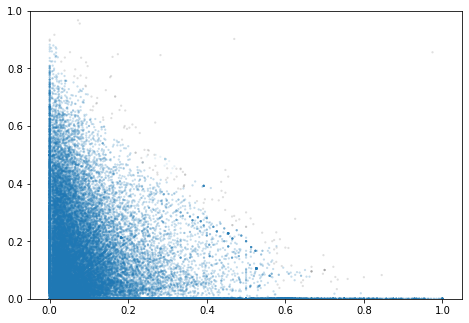

In [67]:
color_palette = sns.color_palette('Paired', 110000)
print(len(color_palette))
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
# cluster_member_colors = [sns.desaturate(x, p) for x, p in
#                          zip(cluster_colors, clusterer.probabilities_)]

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_ylim([0, 1])

ax.scatter(X["comment_density"], X["ds_density"], s=5, linewidth=0, c=cluster_colors, alpha=0.25)

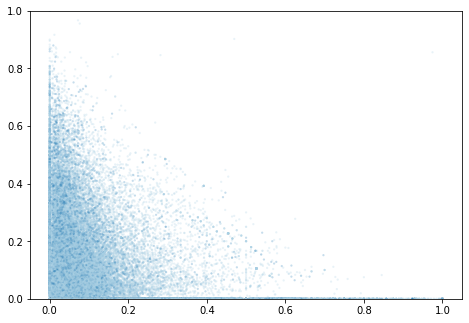

In [69]:
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in pop_class]

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_ylim([0, 1])

ax.scatter(X["comment_density"], X["ds_density"], s=5, linewidth=0, c=cluster_colors, alpha=0.25)